In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as integrate
%matplotlib inline
matplotlib.rcParams.update({
    'font.size': 20,
    'figure.figsize': (10,6),
    'text.usetex': True,
    'grid.linestyle': ':'
})

In [2]:
N = 20
rMax = 10
samples = 1000
dx = rMax/samples

In [3]:
def deriv(phi):
    return np.gradient(phi, dx)

def innerProd(u, v, r):
    integrand = 2*np.pi*u*v*r
    return integrate.simps(integrand, r)

def projection(u, v, r):
    return (innerProd(u, v, r) / innerProd(u, u, r))*u

def gramSchmidt(vectors, r = np.linspace(0, rMax, samples)):
    orthoNorm = []
    for i in range(len(vectors)):
        for j in range(len(orthoNorm)):
            vectors[i] = vectors[i] -  projection(orthoNorm[j], vectors[i], r)
        orthoNorm.append(vectors[i]/np.sqrt(innerProd(vectors[i], vectors[i], r)))
    return np.array(orthoNorm)

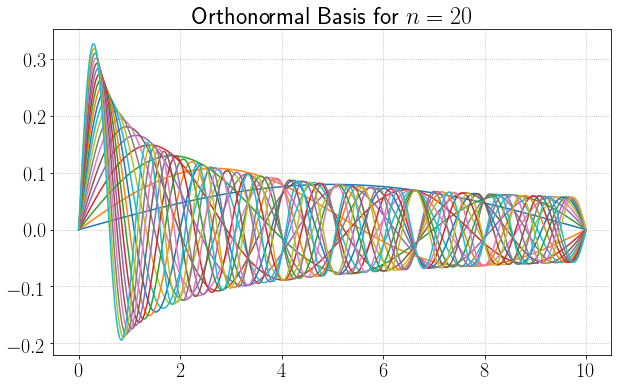

In [4]:
x = np.linspace(0, rMax, samples)
basis = [np.sin(np.pi*n*x/rMax) for n in range(1, N + 1)]
orthNorm = gramSchmidt(basis, x)
for el in orthNorm:
    plt.plot(x, el)
plt.grid()
plt.title(r'Orthonormal Basis for $n = {0}$'.format(N))
#plt.savefig('/Users/natestemen/Desktop/basis.pdf')

In [5]:
innerProds = [[] for _ in orthNorm] #[[] for i in range(len(orthNorm))]
for i in range(len(orthNorm)):
    for j in range(i + 1):
        innerProds[i].append(innerProd(orthNorm[i],orthNorm[j], x))

for i in range(len(innerProds)):
    for j in range(i):
        if innerProds[i][j] > 1e-16:
            print(i,j,':', innerProds[i][j])

12 11 : 1.24685367418e-16
19 18 : 1.82387792884e-16


In [6]:
def approx_soln(var):
    if len(var) != N:
        print('variational vector not of correct size')
    else:
        approx = np.zeros(len(orthNorm[0]))
        for i in range(len(var)):
            approx += var[i]*orthNorm[i]
        return approx

In [7]:
def functional(varVector, n=1, a=2, b=1.1, lam=1):
    phi = approx_soln(varVector)
    dphi = deriv(phi)
    kinetic1 = x*(dphi**2)
    kinetic2 = (n**2)*(phi**2)[1:]/x[1:]
    kinetic2 = np.insert(kinetic2,0,0)
    kinetic = kinetic1 + kinetic2
    potential = phi**6 - a*(phi**4) + b*(phi**2)
    integrand = 0.5*kinetic + lam*x*potential
    return integrate.simps(integrand, x)

$$I[\phi] = \int_0^R \left[\frac{1}{2}\left(\rho\phi_\rho^2 + \frac{n^2}{\rho}\phi^2\right) + \lambda\rho\left(\phi^6 - a\phi^4 + b\phi^2\right)\right]\mathrm{d}\rho$$

In [8]:
def omega_calc(soln, n = 1, a = 2, b = 1.1, lam = 1):
    J0 = 2*np.pi*integrate.simps(x*(soln**2),x)
    dsoln = deriv(soln)
    kinetic1 = x*(dsoln**2)
    kinetic2 = (n**2/x[1:])*(soln[1:]**2)
    kinetic2 = np.insert(kinetic2, 0, 0)
    potential = 6*(soln**6) - 4*a*(soln**4) + 2*b*(soln**2)
    integrand = kinetic1 + kinetic2 + lam*x*potential
    return np.sqrt((2*np.pi/J0)*integrate.simps(integrand, x))

$$\rho^2\phi_{\rho\rho} + \rho\phi_\rho - n^2\phi - \lambda\rho^2\left(6\phi^5 - 4a\phi^3 + 2b\phi\right) + \omega^2\rho^2 \phi = 0$$

In [9]:
def error(soln, omega, n = 1, a = 2, b = 1.1, lam = 1):
    dsoln = np.gradient(soln, dx)
    ddsoln = np.gradient(dsoln, dx)
    first = (x**2)*ddsoln
    second = x*dsoln
    third = -1*(n**2)*soln
    fourth = -1*lam*(x**2)*(6*soln**5 - 4*a*soln**3 + 2*b*soln)
    fifth = (omega**2)*(x**2)*soln
    DE = first + second + third + fourth + fifth
#     return DE
    return integrate.simps(DE**2, x)

In [10]:
def Q_calc(soln, omega):
    return 4*np.pi*omega*integrate.simps(x*(soln**2), x)

In [11]:
def min_func(J0, n=1, a=2, b=1.1, lam=1, disp=False, succ=False):
    '''returns solution array, omega, charge Q, and error'''
    guess = np.array([np.sqrt(J0/N) for i in range(N)])
    cons = ({'type': 'eq', 'fun': lambda x:  sum(x**2) - J0})
    ops = ({'maxiter': 1000, 'disp': disp, 'ftol': 1e-10})
    minimum = minimize(functional, guess, args = (n, a, b, lam), constraints=cons, optionsK=ops)
#     return minimum
    soln = approx_soln(minimum.x)
    omega = omega_calc(soln, n, a, b, lam)
    err = error(soln, omega, n, a, b, lam)
    noether = Q_calc(soln, omega)
    if succ:
        return soln, omega, noether, err, minimum.success
    return soln, omega, noether, err

In [12]:
def vary_pow(Js, n = 1, a = 2, b = 1.1, lam = 1):
    solns = {}
    omegs = {}
    errs = {}
    charges = {}
    for j in Js:
        print(j)
        s,o,q,e,t = min_func(j, n, a, b, lam, succ = True)#, disp=True)
        solns[j] = s
        omegs[j] = o
        charges[j] = q
        errs[j] = e
    return solns, omegs, charges, errs

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.217599234788997
            Iterations: 89
            Function evaluations: 2020
            Gradient evaluations: 89


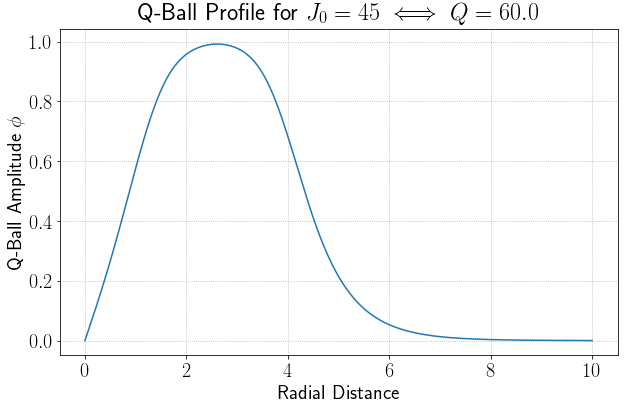

In [13]:
J = 45
spin = 1
s,o,q,e = min_func(J, n = spin, disp = True)
plt.plot(np.linspace(0, rMax, samples), abs(s))
plt.xlabel('Radial Distance')
plt.ylabel('Q-Ball Amplitude $\phi$')
plt.title('Q-Ball Profile for $J_0 = {0}\iff Q = {1}$'.format(J, round(q,2)))
plt.grid()
#plt.savefig('/Users/natestemen/Desktop/qballprof30.pdf')

In [14]:
Q_calc(s,o)

59.997603408040931

In [15]:
e

0.041046588513460137

In [16]:
o

0.66664003786679993

In [17]:
pows = np.arange(10, 100, 20)
s,o,q,e = vary_pow(pows)

10
30
50
70
90


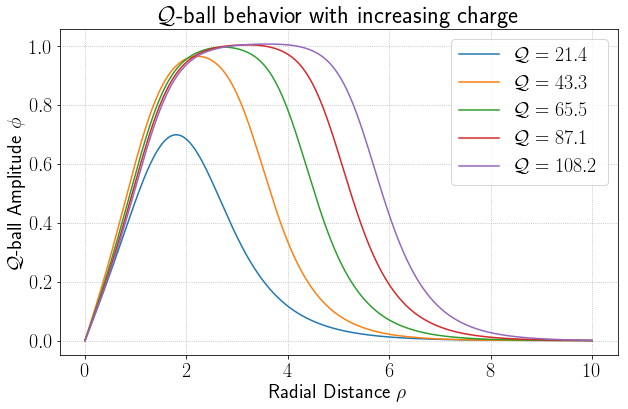

In [30]:
for key in s:
    plt.plot(x, abs(s[key]), label = '$\mathcal{Q} = $' + ' ' + '${0}$'.format(round(q[key],1)))
    plt.legend()
    plt.grid()
    plt.xlabel(r'Radial Distance $\rho$')
    plt.ylabel('$\mathcal{Q}$-ball Amplitude $\phi$')
    plt.title('$\mathcal{Q}$-{ball} behavior with increasing charge')
# plt.savefig('/Users/natestemen/Desktop/varypowercharge.pdf')

In [31]:
for key in s:
    print(str(round(e[key], 4)) + ',')

0.0104,
0.2015,
0.1488,
0.117,
0.1227,


In [20]:
for n in o:
    print(str(n) +  ' & ' + str(round(o[n],5)) + ' & ' +  str(round(e[n],5)) + '\t \\\\ \hline')

10 & 1.06898 & 0.01044	 \\ \hline
30 & 0.72114 & 0.20152	 \\ \hline
50 & 0.65492 & 0.1488	 \\ \hline
70 & 0.62207 & 0.11702	 \\ \hline
90 & 0.6012 & 0.12272	 \\ \hline


In [90]:
powers = np.linspace(0.1, 200.1, 401)
sScan1,oScan1,qScan1,eScan1 = vary_pow(powers, n = 1)

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1
9.6
10.1
10.6
11.1
11.6
12.1
12.6
13.1
13.6
14.1
14.6
15.1
15.6
16.1
16.6
17.1
17.6
18.1
18.6
19.1
19.6
20.1
20.6
21.1
21.6
22.1
22.6
23.1
23.6
24.1
24.6
25.1
25.6
26.1
26.6
27.1
27.6
28.1
28.6
29.1
29.6
30.1
30.6
31.1
31.6
32.1
32.6
33.1
33.6
34.1
34.6
35.1
35.6
36.1
36.6
37.1
37.6
38.1
38.6
39.1
39.6
40.1
40.6
41.1
41.6
42.1
42.6
43.1
43.6
44.1
44.6
45.1
45.6
46.1
46.6
47.1
47.6
48.1
48.6
49.1
49.6
50.1
50.6
51.1
51.6
52.1
52.6
53.1
53.6
54.1
54.6
55.1
55.6
56.1
56.6
57.1
57.6
58.1
58.6
59.1
59.6
60.1
60.6
61.1
61.6
62.1
62.6
63.1
63.6
64.1
64.6
65.1
65.6
66.1
66.6
67.1
67.6
68.1
68.6
69.1
69.6
70.1
70.6
71.1
71.6
72.1
72.6
73.1
73.6
74.1
74.6
75.1
75.6
76.1
76.6
77.1
77.6
78.1
78.6
79.1
79.6
80.1
80.6
81.1
81.6
82.1
82.6
83.1
83.6
84.1
84.6
85.1
85.6
86.1
86.6
87.1
87.6
88.1
88.6
89.1
89.6
90.1
90.6
91.1
91.6
92.1
92.6
93.1
93.6
94.1
94.6
95.1
95.6
96.1
96.6
97.1
97.6
98.1
98.6
99.1
99.6
100.1
100.6
101.1
10

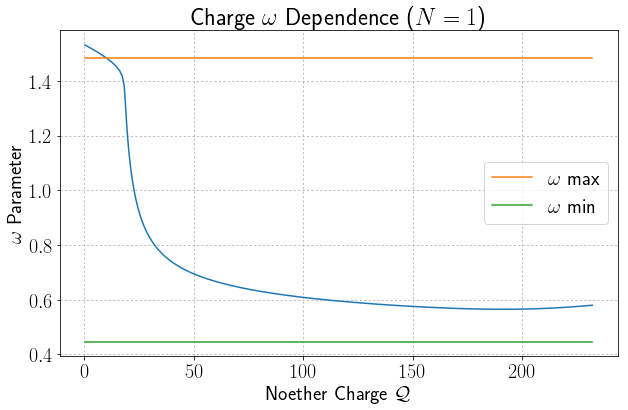

In [127]:
plt.plot(list(qScan1.values()),list(oScan1.values()))
# plt.plot(list(qScan1.values()),list(eScan1.values()))
plt.plot(list(qScan1.values()), [1.483 for _ in list(qScan1.values())], label = '$\omega$ max')
plt.plot(list(qScan1.values()), [0.447 for _ in list(qScan1.values())], label = '$\omega$ min')
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence ($N = 1$)')
plt.legend()
plt.grid()
# plt.xlim([5,15])
# plt.ylim([1.4,1.6])
plt.savefig('/Users/natestemen/Desktop/omegascan.pdf')

In [96]:
sScan2,oScan2,qScan2,eScan2 = vary_pow(powers, n = 2)
# print('==============')
# print('STARTING N = 3')
# print('==============')
# sScan3,oScan3,qScan3,eScan3 = vary_pow(powers, n = 3)
# print('==============')
# print('STARTING N = 4')
# print('==============')
# sScan4,oScan4,qScan4,eScan4 = vary_pow(powers, n = 4)

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1
9.6
10.1
10.6
11.1
11.6
12.1
12.6
13.1
13.6
14.1
14.6
15.1
15.6
16.1
16.6
17.1
17.6
18.1
18.6
19.1
19.6
20.1
20.6
21.1
21.6
22.1
22.6
23.1
23.6
24.1
24.6
25.1
25.6
26.1
26.6
27.1
27.6
28.1
28.6
29.1
29.6
30.1
30.6
31.1
31.6
32.1
32.6
33.1
33.6
34.1
34.6
35.1
35.6
36.1
36.6
37.1
37.6
38.1
38.6
39.1
39.6
40.1
40.6
41.1
41.6
42.1
42.6
43.1
43.6
44.1
44.6
45.1
45.6
46.1
46.6
47.1
47.6
48.1
48.6
49.1
49.6
50.1
50.6
51.1
51.6
52.1
52.6
53.1
53.6
54.1
54.6
55.1
55.6
56.1
56.6
57.1
57.6
58.1
58.6
59.1
59.6
60.1
60.6
61.1
61.6
62.1
62.6
63.1
63.6
64.1
64.6
65.1
65.6
66.1
66.6
67.1
67.6
68.1
68.6
69.1
69.6
70.1
70.6
71.1
71.6
72.1
72.6
73.1
73.6
74.1
74.6
75.1
75.6
76.1
76.6
77.1
77.6
78.1
78.6
79.1
79.6
80.1
80.6
81.1
81.6
82.1
82.6
83.1
83.6
84.1
84.6
85.1
85.6
86.1
86.6
87.1
87.6
88.1
88.6
89.1
89.6
90.1
90.6
91.1
91.6
92.1
92.6
93.1
93.6
94.1
94.6
95.1
95.6
96.1
96.6
97.1
97.6
98.1
98.6
99.1
99.6
100.1
100.6
101.1
10

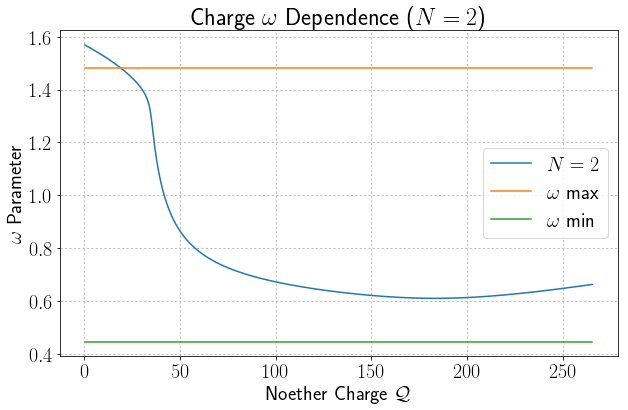

In [99]:
# plt.plot(list(qScan1.values()),list(oScan1.values()))#, label = '$N = 1$')
plt.plot(list(qScan2.values()),list(oScan2.values()), label = '$N = 2$')
# plt.plot(list(qScan3.values()),list(oScan3.values()), label = '$N = 3$')
# plt.plot(list(qScan4.values()),list(oScan4.values()), label = '$N = 4$')
plt.plot(list(qScan2.values()), [1.483 for _ in list(qScan2.values())], label = '$\omega$ max')
plt.plot(list(qScan2.values()), [0.447 for _ in list(qScan2.values())], label = '$\omega$ min')
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence ($N = 2$)')
plt.legend()
plt.grid()
# plt.xlim([0,800])
# plt.ylim([.447,1.483])

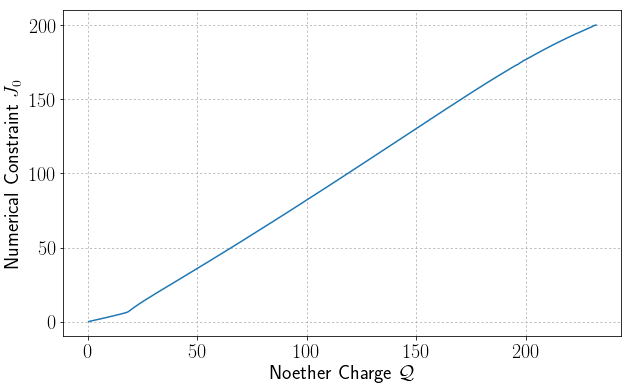

In [218]:
plt.plot([i for i in qScan.values()], np.linspace(0.1, 200.1, 401))
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.ylabel('Numerical Constraint $J_0$')
plt.grid()

In [180]:
powers = np.linspace(0.1, 100, 21)
sScanSpin,oScanSpin,qScanSpin,eScanSpin = vary_pow(powers, n = 2)

0.1
5.095
10.09
15.085
20.08
25.075
30.07
35.065
40.06
45.055
50.05
55.045
60.04
65.035
70.03
75.025
80.02
85.015
90.01
95.005
100.0


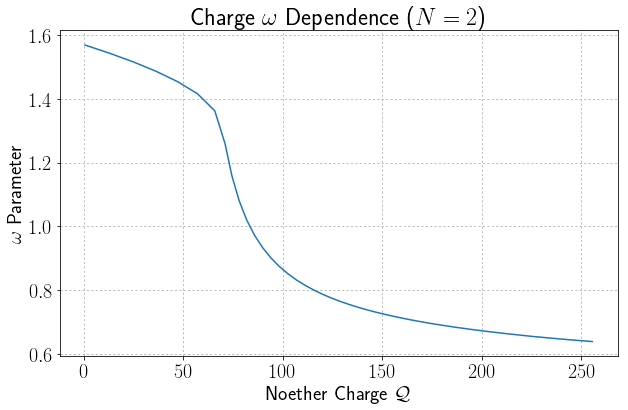

In [170]:
plt.plot([i for i in qScanSpin.values()],[i for i in oScanSpin.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence ($N = 2$)')
plt.grid()

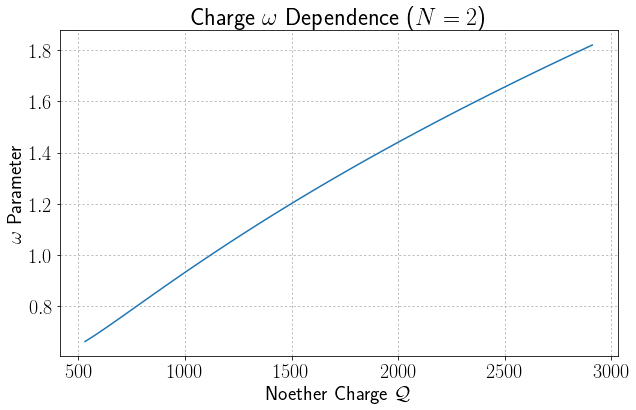

In [156]:
plt.plot([i for i in qScanSpin.values()],[i for i in oScanSpin.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence ($N = 2$)')
plt.grid()

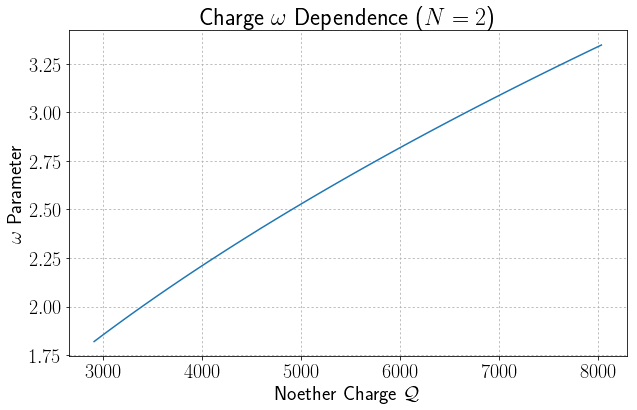

In [158]:
plt.plot([i for i in qScanSpin.values()],[i for i in oScanSpin.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence ($N = 2$)')
plt.grid()

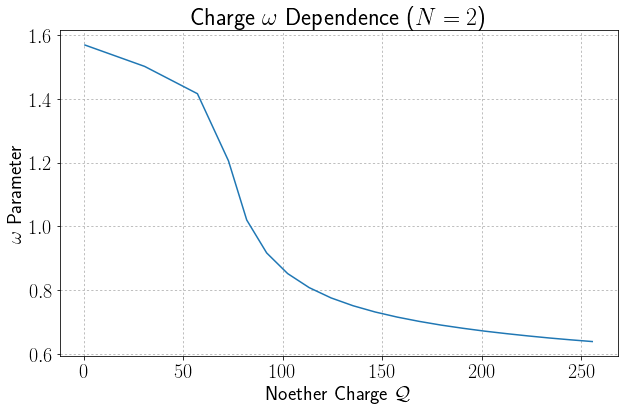

In [181]:
plt.plot([i for i in qScanSpin.values()],[i for i in oScanSpin.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence ($N = 2$)')
plt.grid()

In [148]:
powers = np.linspace(200, 400, 401)
sScan1,oScan1,qScan1,eScan1 = vary_pow(powers)

200.0
200.5
201.0
201.5
202.0
202.5
203.0
203.5
204.0
204.5
205.0
205.5
206.0
206.5
207.0
207.5
208.0
208.5
209.0
209.5
210.0
210.5
211.0
211.5
212.0
212.5
213.0
213.5
214.0
214.5
215.0
215.5
216.0
216.5
217.0
217.5
218.0
218.5
219.0
219.5
220.0
220.5
221.0
221.5
222.0
222.5
223.0
223.5
224.0
224.5
225.0
225.5
226.0
226.5
227.0
227.5
228.0
228.5
229.0
229.5
230.0
230.5
231.0
231.5
232.0
232.5
233.0
233.5
234.0
234.5
235.0
235.5
236.0
236.5
237.0
237.5
238.0
238.5
239.0
239.5
240.0
240.5
241.0
241.5
242.0
242.5
243.0
243.5
244.0
244.5
245.0
245.5
246.0
246.5
247.0
247.5
248.0
248.5
249.0
249.5
250.0
250.5
251.0
251.5
252.0
252.5
253.0
253.5
254.0
254.5
255.0
255.5
256.0
256.5
257.0
257.5
258.0
258.5
259.0
259.5
260.0
260.5
261.0
261.5
262.0
262.5
263.0
263.5
264.0
264.5
265.0
265.5
266.0
266.5
267.0
267.5
268.0
268.5
269.0
269.5
270.0
270.5
271.0
271.5
272.0
272.5
273.0
273.5
274.0
274.5
275.0
275.5
276.0
276.5
277.0
277.5
278.0
278.5
279.0
279.5
280.0
280.5
281.0
281.5
282.0
282.5
283.

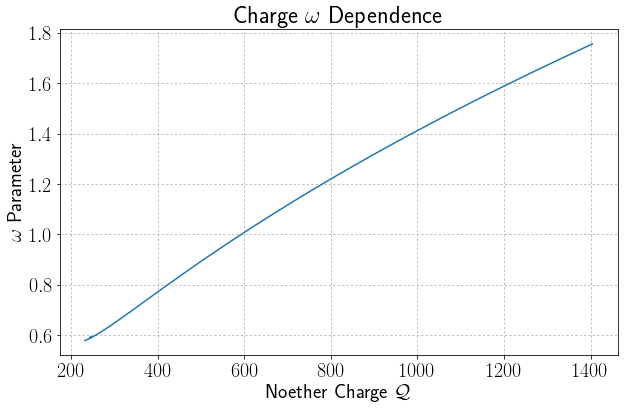

In [149]:
plt.plot([i for i in qScan1.values()],[i for i in oScan1.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence')
plt.grid()

In [150]:
powers = np.linspace(400, 600, 201)
sScan2,oScan2,qScan2,eScan2 = vary_pow(powers)

400.0
401.0
402.0
403.0
404.0
405.0
406.0
407.0
408.0
409.0
410.0
411.0
412.0
413.0
414.0
415.0
416.0
417.0
418.0
419.0
420.0
421.0
422.0
423.0
424.0
425.0
426.0
427.0
428.0
429.0
430.0
431.0
432.0
433.0
434.0
435.0
436.0
437.0
438.0
439.0
440.0
441.0
442.0
443.0
444.0
445.0
446.0
447.0
448.0
449.0
450.0
451.0
452.0
453.0
454.0
455.0
456.0
457.0
458.0
459.0
460.0
461.0
462.0
463.0
464.0
465.0
466.0
467.0
468.0
469.0
470.0
471.0
472.0
473.0
474.0
475.0
476.0
477.0
478.0
479.0
480.0
481.0
482.0
483.0
484.0
485.0
486.0
487.0
488.0
489.0
490.0
491.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
502.0
503.0
504.0
505.0
506.0
507.0
508.0
509.0
510.0
511.0
512.0
513.0
514.0
515.0
516.0
517.0
518.0
519.0
520.0
521.0
522.0
523.0
524.0
525.0
526.0
527.0
528.0
529.0
530.0
531.0
532.0
533.0
534.0
535.0
536.0
537.0
538.0
539.0
540.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
549.0
550.0
551.0
552.0
553.0
554.0
555.0
minimization failed for J = 555.0
556.0
557.0
558.0
559.0
560.0


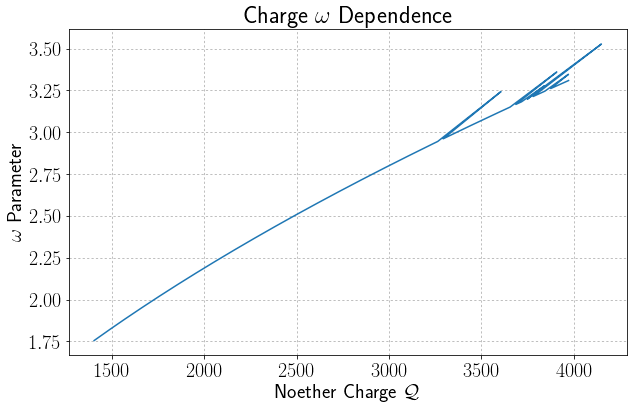

In [151]:
plt.plot([i for i in qScan2.values()],[i for i in oScan2.values()])
#plt.plot([i for i in o.values()], powers)
plt.ylabel('$\omega$ Parameter')
plt.xlabel('Noether Charge $\mathcal{Q}$')
plt.title('Charge $\omega$ Dependence')
plt.grid()

Want to show if this is correct, so need some error estimate. $$\int_0^R(D\phi)^2 = 0$$

$$D\phi = \phi_{\rho\rho}+\dfrac{1}{\rho}\phi_{\rho}-\dfrac{n^2}{\rho^2}\phi-\lambda\left(6\phi^5-4a\phi^3+2b\phi\right)+\omega^2\phi = 0$$

This is equivalent to
$$\rho^2\phi_{\rho\rho} + \rho\phi_\rho - n^2\phi - \lambda\rho^2\left(6\phi^5 - 4a\phi^3 + 2b\phi\right) + \omega^2\rho^2 \phi = 0$$

In [31]:
def findMins(ns, Js, a, b, lam):
    if len(ns) != len(Js):
        raise ValueError('ns and Js need to be same length!')
    solns = {}
    omegs = {}
    charges = {}
    errs = {}
    ops = ({'maxiter': 1000, 'disp': False})
    for i in range(len(ns)):
        cons = ({'type': 'eq', 'fun': lambda x: sum(x**2) - Js[i]})
        start = np.array([np.sqrt(Js[i]/N) for _ in range(N)])
        minimum = minimize(functional, start, args = (ns[i], a, b, lam), constraints = cons, options = ops)
        
#     for n in nVals:
#         minimum = minimize(functional, start, args = (n, a, b, lam), constraints = cons, options = ops)
        minVarVector = minimum.x
        soln = approx_soln(minVarVector)
        omega = omega_calc(soln, ns[i], a, b, lam)
        err = error(soln, omega, ns[i], a, b, lam)
        charge = Q_calc(soln, omega)
        solns[ns[i]] = soln
        omegs[ns[i]] = omega
        errs[ns[i]] = err
        charges[ns[i]] = charge
    return solns, omegs, charges, errs

In [80]:
s,o,q,e = findMins([1,2,3,4], [45.0018, 38.116, 29.19, 23.00], 2, 1.1, 1)

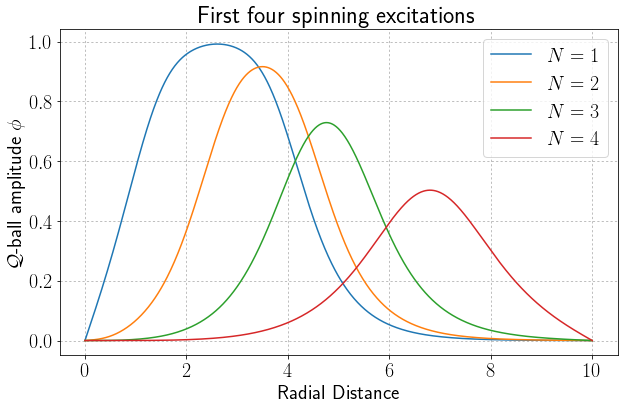

In [81]:
for ind in s:
    plt.plot(x, abs(s[ind]), label = "$N = {0}$".format(ind))
plt.legend()
plt.title('First four spinning excitations')
plt.ylabel('$\mathcal{Q}$-ball amplitude $\phi$')
plt.xlabel('Radial Distance ')
plt.grid()
plt.savefig('/Users/natestemen/Desktop/firstfour.pdf')

In [122]:
for key in s:
    print(round(e[key],4))

0.0104
0.2015
0.1488
0.117
0.1227


In [ ]:
integrate.simps()